# Run the fusion EasyVVUQ campaign

Run an EasyVVUQ campaign to analyze the sensitivity of the temperature
profile predicted by a simplified model of heat conduction in a
tokamak plasma.

This is done with PCE.

In [1]:
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib
if not os.getenv("DISPLAY"): matplotlib.use('Agg')
import matplotlib.pylab as plt

In [2]:
# routine to write out (if needed) the fusion .template file

def write_template(params):
    str = ""
    first = True
    for k in params.keys():
        if first:
            str += '{"%s": "$%s"' % (k,k) ; first = False
        else:
            str += ', "%s": "$%s"' % (k,k)
    str += '}'
    print(str, file=open('fusion.template','w'))

In [3]:
# routine to run a PCE campaign

def run_pce_case(pce_order=2, local=True):
    
    times = np.zeros(9)

    time_start = time.time()
    time_start_whole = time_start
    # Set up a fresh campaign called "fusion_pce."
    my_campaign = uq.CampaignDask(name='fusion_pce.')

    # Define parameter space
    params = {
        "Qe_tot":   {"type": "float",   "min": 1.0e6, "max": 50.0e6, "default": 2e6},
        "H0":       {"type": "float",   "min": 0.00,  "max": 1.0,    "default": 0},
        "Hw":       {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 0.1},
        "Te_bc":    {"type": "float",   "min": 10.0,  "max": 1000.0, "default": 100},
        "chi":      {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 1},
        "a0":       {"type": "float",   "min": 0.2,   "max": 10.0,   "default": 1},
        "R0":       {"type": "float",   "min": 0.5,   "max": 20.0,   "default": 3},
        "E0":       {"type": "float",   "min": 1.0,   "max": 10.0,   "default": 1.5},
        "b_pos":    {"type": "float",   "min": 0.95,  "max": 0.99,   "default": 0.98},
        "b_height": {"type": "float",   "min": 3e19,  "max": 10e19,  "default": 6e19},
        "b_sol":    {"type": "float",   "min": 2e18,  "max": 3e19,   "default": 2e19},
        "b_width":  {"type": "float",   "min": 0.005, "max": 0.025,  "default": 0.01},
        "b_slope":  {"type": "float",   "min": 0.0,   "max": 0.05,   "default": 0.01},
        "nr":       {"type": "integer", "min": 10,    "max": 1000,   "default": 100},
        "dt":       {"type": "float",   "min": 1e-3,  "max": 1e3,    "default": 100},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

    # Create an encoder and decoder for PCE test app
    encoder = uq.encoders.GenericEncoder(template_fname='fusion.template',
                                         delimiter='$',
                                         target_filename='fusion_in.json')


    decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                    output_columns=["te", "ne", "rho", "rho_norm"])

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="fusion", params=params, encoder=encoder, decoder=decoder)

    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Create the sampler
    vary = {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "H0":       cp.Uniform(0.0,   0.2),
        "Hw":       cp.Uniform(0.1,   0.5),
        "chi":      cp.Uniform(0.8,   1.2),
        "Te_bc":    cp.Uniform(80.0,  120.0)
    }
    """ other possible quantities to vary
        "a0":       cp.Uniform(0.9,   1.1),
        "R0":       cp.Uniform(2.7,   3.3),
        "E0":       cp.Uniform(1.4,   1.6),
        "b_pos":    cp.Uniform(0.95,  0.99),
        "b_height": cp.Uniform(5e19,  7e19),
        "b_sol":    cp.Uniform(1e19,  3e19),
        "b_width":  cp.Uniform(0.015, 0.025),
        "b_slope":  cp.Uniform(0.005, 0.020)
    """

    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.PCESampler(vary=vary, polynomial_order=pce_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Create and populate the run directories
    my_campaign.populate_runs_dir()

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    if local:
        print('Running locally')
        from dask.distributed import Client, LocalCluster
        client = Client(processes=True, threads_per_worker=1)
    else:
        print('Running using SLURM')
        from dask.distributed import Client
        from dask_jobqueue import SLURMCluster
        cluster = SLURMCluster(
            job_extra=['--qos=p.tok.openmp.2h', '--mail-type=end', '--mail-user=dpc@rzg.mpg.de', '-t 2:00:00'], 
            queue='p.tok.openmp', 
            cores=8, 
            memory='8 GB',
            processes=8)
        cluster.scale(32)
        print(cluster)
        print(cluster.job_script())
        client = Client(cluster)
    print(client)

    # Run the cases
    cwd = os.getcwd().replace(' ', '\ ')      # deal with ' ' in the path
    cmd = f"{cwd}/fusion_model.py fusion_in.json"
    my_campaign.apply_for_each_run_dir(uq.actions.ExecuteLocal(cmd, interpret='python3'), client)

    client.close()
    if not local:
        client.shutdown()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Collate the results
    my_campaign.collate()
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Post-processing analysis
    my_campaign.apply_analysis(uq.analysis.PCEAnalysis(sampler=my_campaign.get_active_sampler(), qoi_cols=["te", "ne", "rho", "rho_norm"]))

    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    time_start = time.time()
    # Get Descriptive Statistics
    results = my_campaign.get_last_analysis()

    time_end = time.time()
    times[7] = time_end-time_start
    print('Time for phase 7 = %.3f' % (times[7]))

    time_start = time.time()
    # Save the campaign and results
    my_campaign.save_state("campaign_state.json")
    pickle.dump(results, open('fusion_results.pickle','bw'))
    time_end = time.time()
    times[8] = time_end-time_start
    print('Time for phase 8 = %.3f' % (times[8]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, pce_order, my_campaign.get_active_sampler().count

In [14]:
# routines for plotting the results

def plot_Te(results, title=None):
    # plot the calculated Te: mean, with std deviation, 1, 10, 90 and 99%
    plt.figure()
    rho = results.describe('rho', 'mean')
    plt.plot(rho, results.describe('te', 'mean'), 'b-', label='Mean')
    plt.plot(rho, results.describe('te', 'mean')-results.describe('te', 'std'), 'b--', label='+1 std deviation')
    plt.plot(rho, results.describe('te', 'mean')+results.describe('te', 'std'), 'b--')
    plt.fill_between(rho, results.describe('te', 'mean')-results.describe('te', 'std'), results.describe('te', 'mean')+results.describe('te', 'std'), color='b', alpha=0.2)
    plt.plot(rho, results.describe('te', '10%'), 'b:', label='10 and 90 percentiles')
    plt.plot(rho, results.describe('te', '90%'), 'b:')
    plt.fill_between(rho, results.describe('te', '10%'), results.describe('te', '90%'), color='b', alpha=0.1)
    plt.fill_between(rho, results.describe('te', '1%'), results.describe('te', '99%'), color='b', alpha=0.05)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('Te [$eV$]')
    if not title is None: plt.title(title)
    plt.savefig('Te.png')
    plt.savefig('Te.pdf')

def plot_ne(results, title=None):
    # plot the calculated ne: mean, with std deviation, 1, 10, 90 and 99%
    plt.figure()
    rho = results.describe('rho', 'mean')
    plt.plot(rho, results.describe('ne', 'mean'), 'b-', label='Mean')
    plt.plot(rho, results.describe('ne', 'mean')-results.describe('ne', 'std'), 'b--', label='+1 std deviation')
    plt.plot(rho, results.describe('ne', 'mean')+results.describe('ne', 'std'), 'b--')
    plt.fill_between(rho, results.describe('ne', 'mean')-results.describe('ne', 'std'), results.describe('ne', 'mean')+results.describe('ne', 'std'), color='b', alpha=0.2)
    plt.plot(rho, results.describe('ne', '10%'), 'b:', label='10 and 90 percentiles')
    plt.plot(rho, results.describe('ne', '90%'), 'b:')
    plt.fill_between(rho, results.describe('ne', '10%'), results.describe('ne', '90%'), color='b', alpha=0.1)
    plt.fill_between(rho, results.describe('ne', '1%'), results.describe('ne', '99%'), color='b', alpha=0.05)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('ne [$m^{-3}$]')
    if not title is None: plt.title(title)
    plt.savefig('ne.png')
    plt.savefig('ne.pdf')

def plot_sobols_first(results, title=None):
    # plot the first Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k in results.sobols_first()['te'].keys(): plt.plot(rho, results.sobols_first()['te'][k], label=k)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_first')
    if not title is None: plt.title(title)
    plt.savefig('sobols_first.png')
    plt.savefig('sobols_first.pdf')

def plot_sobols_second(results, title=None):
    # plot the second Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k1 in results.sobols_second()['te'].keys():
        for k2 in results.sobols_second()['te'][k1].keys():
            plt.plot(rho, results.sobols_second()['te'][k1][k2], label=k1+'/'+k2)
    plt.legend(loc=0, ncol=2)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_second')
    if not title is None: plt.title(title)
    plt.savefig('sobols_second.png')
    plt.savefig('sobols_second.pdf')

def plot_sobols_total(results, title=None):
    # plot the total Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k in results.sobols_total()['te'].keys(): plt.plot(rho, results.sobols_total()['te'][k], label=k)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_total')
    if not title is None: plt.title(title)
    plt.savefig('sobols_total.png')
    plt.savefig('sobols_total.pdf')

def plot_distribution(results, results_df, title=None):
    te_dist = results.raw_data['output_distributions']['te']
    rho_norm = results.describe('rho_norm', 'mean')
    for i in [np.maximum(0, int(i-1)) 
              for i in np.linspace(0,1,5) * rho_norm.shape]:
        plt.figure()
        pdf_raw_samples = cp.GaussianKDE(results_df.te[i])
        pdf_kde_samples = cp.GaussianKDE(te_dist.samples[i])
        plt.hist(results_df.te[i], density=True, bins=50, label='histogram of raw samples', alpha=0.25)
        if hasattr(te_dist, 'samples'):
            plt.hist(te_dist.samples[i], density=True, bins=50, label='histogram of kde samples', alpha=0.25)

        plt.plot(np.linspace(pdf_raw_samples.lower, pdf_raw_samples.upper), pdf_raw_samples.pdf(np.linspace(pdf_raw_samples.lower, pdf_raw_samples.upper)), label='PDF (raw samples)')
        plt.plot(np.linspace(pdf_kde_samples.lower, pdf_kde_samples.upper), pdf_kde_samples.pdf(np.linspace(pdf_kde_samples.lower, pdf_kde_samples.upper)), label='PDF (kde samples)')

        plt.legend(loc=0)
        plt.xlabel('Te [$eV$]')
        if title is None:
            plt.title('Distributions for rho_norm = %0.4f' % (rho_norm[i]))
        else:
            plt.title('%s\nDistributions for rho_norm = %0.4f' % (title, rho_norm[i]))
        plt.savefig('distribution_function_rho_norm=%0.4f.png' % (rho_norm[i]))
        plt.savefig('distribution_function_rho_norm=%0.4f.pdf' % (rho_norm[i]))

In [5]:
# Calculate the polynomial chaos expansion for a range of orders

if __name__ == '__main__':
    local = False

    R = {}
    for pce_order in range(1, 8):
        R[pce_order] = {}
        (R[pce_order]['results_df'], 
         R[pce_order]['results'], 
         R[pce_order]['times'], 
         R[pce_order]['order'], 
         R[pce_order]['number_of_samples']) = run_pce_case(pce_order=pce_order, local=local)

Time for phase 1 = 0.394
Number of samples = 32
Time for phase 2 = 0.829
Time for phase 3 = 0.069
Running using SLURM
SLURMCluster('tcp://130.183.15.203:43277', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:43277 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://

<Client: 'tcp://130.183.15.203:43277' processes=0 threads=0, memory=0 B>
Time for phase 4 = 38.989
Time for phase 5 = 0.774
Time for phase 6 = 1.332
Time for phase 7 = 0.000
Time for phase 8 = 0.266
Time for phase 1 = 0.107
Number of samples = 243
Time for phase 2 = 4.614
Time for phase 3 = 0.495
Running using SLURM
SLURMCluster('tc

/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/chaospy/descriptives/correlation/pearson.py:45: RuntimeWarning: invalid value encountered in sqrt
  vvar = numpy.sqrt(numpy.outer(var, var))


Time for phase 6 = 256.071
Time for phase 7 = 0.000
Time for phase 8 = 0.463
Time for phase 1 = 0.090
Number of samples = 16807
Time for phase 2 = 289.740
Time for phase 3 = 28.485
Running using SLURM
SLURMCluster('tcp://130.183.15.203:45497', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:45497 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://

<Client: 'tcp://130.183.15.203:45497' processes=0 threads=0, memory=0 B>
Time for phase 4 = 675.316
Time for phase 5 = 1086.559


/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/chaospy/descriptives/correlation/pearson.py:45: RuntimeWarning: invalid value encountered in sqrt
  vvar = numpy.sqrt(numpy.outer(var, var))


Time for phase 6 = 1209.963
Time for phase 7 = 0.000
Time for phase 8 = 0.334
Time for phase 1 = 0.426
Number of samples = 32768
Time for phase 2 = 567.269
Time for phase 3 = 61.354
Running using SLURM
SLURMCluster('tcp://130.183.15.203:46415', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:46415 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://

<Client: 'tcp://130.183.15.203:46415' processes=0 threads=0, memory=0 B>
Time for phase 4 = 1249.848
Time for phase 5 = 3318.427


/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/chaospy/descriptives/correlation/pearson.py:45: RuntimeWarning: invalid value encountered in sqrt
  vvar = numpy.sqrt(numpy.outer(var, var))


Time for phase 6 = 5340.825
Time for phase 7 = 0.000
Time for phase 8 = 0.673


In [6]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [16]:
# produce a table of the time taken  for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: creation of run directories
#   4: running the cases
#   5: collation of results
#   6: calculation of statistics including Sobols
#   7: returning of analysed results
#   8: saving campaign and pickled results

pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6','Phase 7', 'Phase 8'], 
             index=[R[r]['order'] for r in list(R.keys())])

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6,Phase 7,Phase 8
1,42.654376,0.394070,0.828983,0.068961,38.988749,0.773937,1.332041,0.000015,0.265560
2,93.215856,0.106508,4.614281,0.495121,79.989655,5.198222,2.573749,0.000007,0.236456
3,110.100018,0.179482,17.050372,1.878606,54.878371,27.460071,8.579037,0.000007,0.072885
4,326.956510,0.287346,56.527286,5.088021,127.078337,90.211688,47.667456,0.000009,0.093648
5,1028.957235,0.303292,131.294859,14.674330,309.130466,317.019216,256.070585,0.000005,0.462544
6,3290.488436,0.090095,289.739820,28.484852,675.316160,1086.558852,1209.963407,0.000003,0.333902
7,10538.824507,0.426233,567.268858,61.354036,1249.848261,3318.426617,5340.824935,0.000003,0.673086


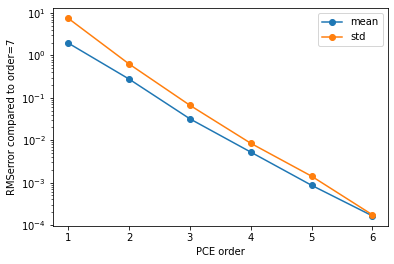

In [12]:
# plot the convergence of the mean and standard deviation to that of the highest order

if __name__ == '__main__':
    plt.figure()
    O = [R[r]['order'] for r in list(R.keys())]
    plt.semilogy([o for o in O[0:-1]],
                 [np.sqrt(np.mean((R[o]['results'].describe('te', 'mean') - 
                                   R[O[-1]]['results'].describe('te', 'mean'))**2)) for o in O[0:-1]],
                 'o-', label='mean')
    plt.semilogy([o for o in O[0:-1]],
                 [np.sqrt(np.mean((R[o]['results'].describe('te', 'std') - 
                                   R[O[-1]]['results'].describe('te', 'std'))**2)) for o in O[0:-1]],
                 'o-', label='std')
    plt.xlabel('PCE order')
    plt.ylabel('RMSerror compared to order=%s' % (O[-1]))
    plt.legend(loc=0)
    plt.savefig('Convergence_mean_std.png')
    plt.savefig('Convergence_mean_std.pdf')

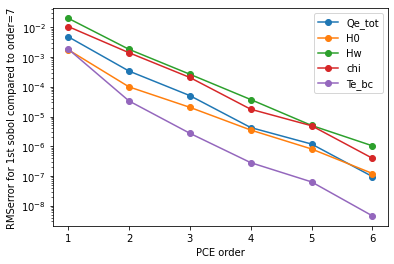

In [10]:
# plot the convergence of the first sobol to that of the highest order

if __name__ == '__main__':
    plt.figure()
    O = [R[r]['order'] for r in list(R.keys())]
    for v in list(R[O[-1]]['results'].sobols_first('te').keys()):
        plt.semilogy([o for o in O[0:-1]],
                     [np.sqrt(np.mean((R[o]['results'].sobols_first('te')[v] - 
                                       R[O[-1]]['results'].sobols_first('te')[v])**2)) for o in O[0:-1]],
                     'o-',
                     label=v)
    plt.xlabel('PCE order')
    plt.ylabel('RMSerror for 1st sobol compared to order=%s' % (O[-1]))
    plt.legend(loc=0)
    plt.savefig('Convergence_sobol_first.png')
    plt.savefig('Convergence_sobol_first.pdf')

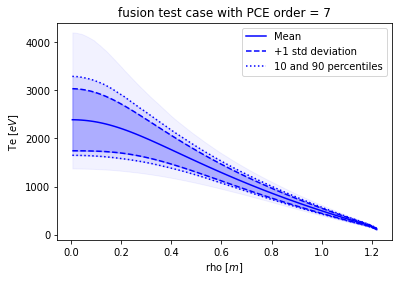

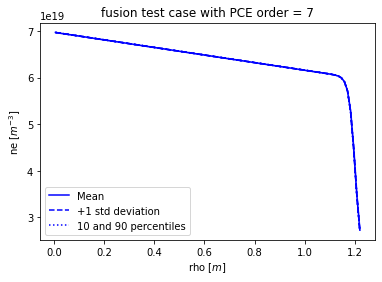

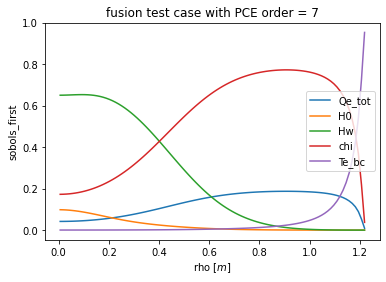

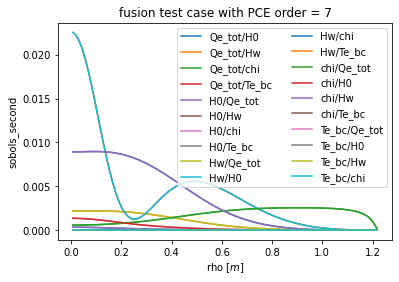

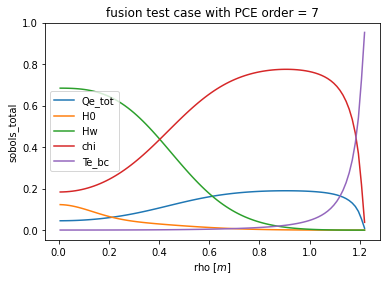

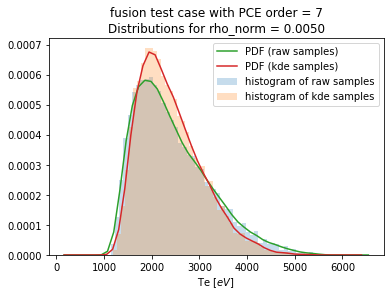

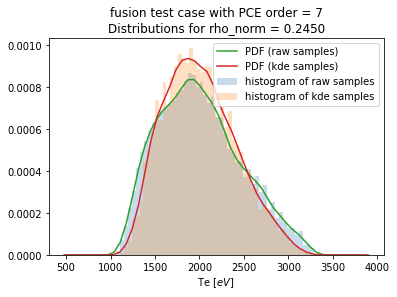

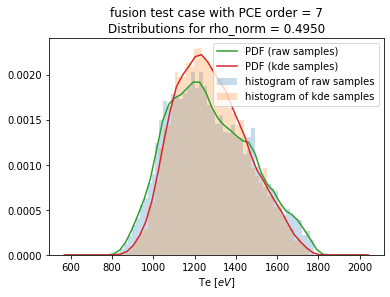

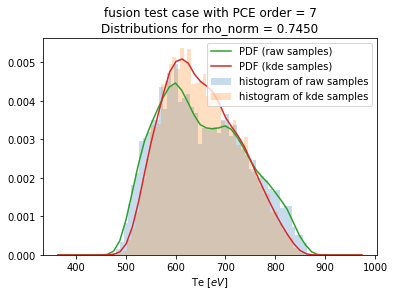

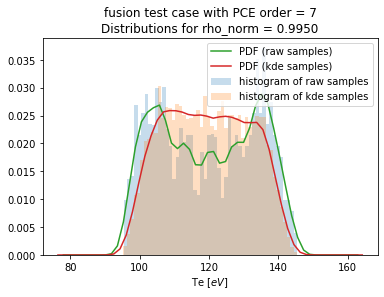

In [15]:
# plot a standard set of graphs for the highest order case

if __name__ == '__main__':
    title = 'fusion test case with PCE order = %i' % list(R.values())[-1]['order']
    plot_Te(list(R.values())[-1]['results'], title)
    plot_ne(list(R.values())[-1]['results'], title)
    plot_sobols_first(list(R.values())[-1]['results'], title)
    plot_sobols_second(list(R.values())[-1]['results'], title)
    plot_sobols_total(list(R.values())[-1]['results'], title)
    plot_distribution(list(R.values())[-1]['results'], list(R.values())[-1]['results_df'], title)